In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib import colormaps as cm
import gaitFunctions
import combineClips
import plotClip
import os
import glob
import seaborn as sns
from scipy import stats
import cv2

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [19]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#703391'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

### Combined data for all clips

In [3]:
# navigate to directory that contains the data
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries')
xl_files = sorted(glob.glob('*.xlsx'))
excel_file = gaitFunctions.selectOneFromList(xl_files)

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
step_df.head(3)


Choose from this list : 
1: exemplaris_2024-01-10.xlsx
2: exemplaris_2024-01-18.xlsx
3: exemplaris_2024-01-25.xlsx
4: exemplaris_2024-02-14.xlsx
5: path_summaries.xlsx
6: step_summaries.xlsx

Which ONE would you like? 4

You chose exemplaris_2024-02-14.xlsx



,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change,clip,treatment,individual,date,uniq_id
0,L1,0.272,1.151,0.879,0.242,1.121,0.7841,1.2720,L1:0.8921,R1:,...,NaN,0.667,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
1,L1,1.393,2.606,1.213,0.303,1.516,0.8001,2.7575,L1:0.9001,R1:0.3701,...,NaN,1.030,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
2,L1,2.909,4.090,1.181,0.334,1.515,0.7795,4.2570,L1:0.8898,R1:0.5597,...,NaN,0.879,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris


# Walking speed vs. step amplitude
### Nirody Figure 2A

n =  4324 strides are shown
ρ = 1.0 p = 0.0


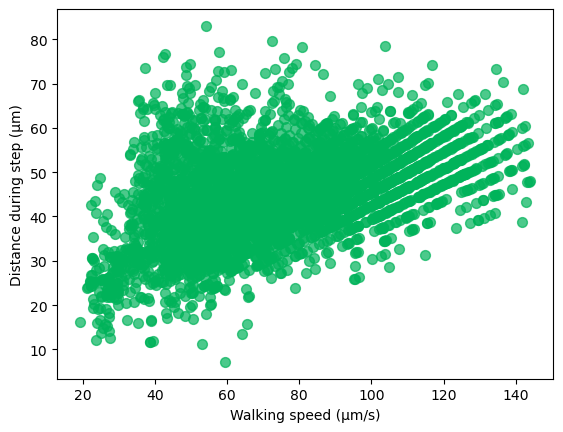

In [4]:
'''

Paper text:
"Step amplitude, defined as the distance between the posterior extreme position (PEP) 
measured at liftoff of a leg at the start of a swing and the anterior extreme position 
(AEP) measured at touchdown of the same leg at the end of swing, increases with forward 
walking speed (Fig. 2A)."

Figure legend:
"Stride length (A) smoothly increases ... with walking speed"

Methods:
"Correlation coefficients between variables were calculated over the entire observed 
walking speed range; we used Spearman ρ to determine correlation due to the nonlinear 
relationships between several of our kinematic variables."

NOTES:  
1. I am only including data when the tardigrades are 'cruising' = not in a stop or a 
turn . . .

2. We define step distance differently = distance traveled by tardigrade during gait cycle.
So this is always going to be correlated to speed. Consider measuring amplitudes . . . 
(lots of re-stepping work)

'''

# only include lateral legs
step_df = step_df[step_df['legID'].isin(['L1','L2','L3','R1','R2','R3'])]

speed_during_steps_scaled = step_df['speed_during_step_scaled'].values * 1000
distance_during_steps_scaled = step_df['distance_during_step_scaled'].values * 1000
mc = '#00b35a'

plt.scatter(speed_during_steps_scaled,distance_during_steps_scaled,c=mc,s=50,alpha=0.7)
plt.ylabel('Distance during step (µm)')
plt.xlabel('Walking speed (µm/s)')
print('n = ', len(speed_during_steps_scaled), 'strides are shown')

r,p = stats.spearmanr(speed_during_steps_scaled,speed_during_steps_scaled)
print('ρ =', np.round(r,2), 'p =', np.round(p,2))

plt.show()

# Forward walking speed vs. Stride period (gait cycle)
### Nirody Figure 2B

n =  4324 strides are shown
ρ = -0.79 p = 0.0


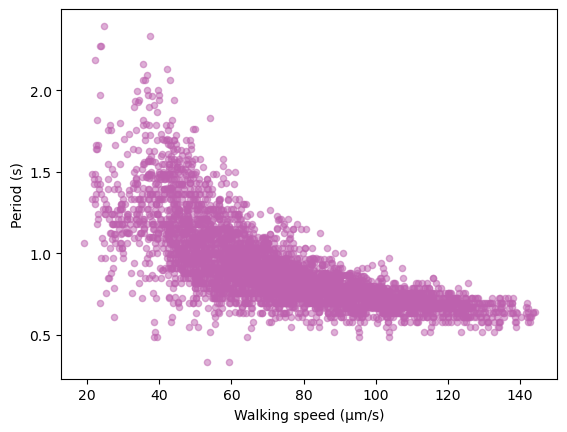

In [20]:
'''
"Stride period decreases with walking speed, plateauing at walking speeds of 
approximately v > 100 μm/s (Fig. 2B)."
'''

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

# only include lateral legs
step_df = step_df[step_df['legID'].isin(['L1','L2','L3','R1','R2','R3'])]

speed_during_steps_scaled = step_df['speed_during_step_scaled'].values * 1000
gait_cycles = step_df['gait'].values
mc = '#bd61ae'

plt.scatter(speed_during_steps_scaled,gait_cycles,c=mc,s=20,alpha=0.5)
plt.ylabel('Period (s)')
plt.xlabel('Walking speed (µm/s)')
print('n = ', len(speed_during_steps_scaled), 'strides are shown')

r,p = stats.spearmanr(speed_during_steps_scaled,gait_cycles)
print('ρ =', np.round(r,2), 'p =', np.round(p,2))

plt.show()

# walking speed vs. 1. stance and swing duration and 2. Duty Factor
### Nirody Figures 2C and Figure 3

### Lateral Legs: walking speed vs. 1. stance and swing duration and 2. Duty Factor

In [6]:
# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

n =  4324 strides are shown
Swing: ρ = -0.26 p = 0.0
Stance: ρ = -0.77 p = 0.0
Duty Factor: ρ = -0.53 p = 0.0


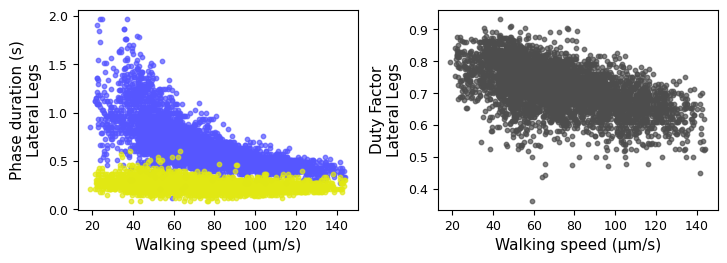

In [7]:
def stanceSwingPlot(ax,df,legs):
    df = df.copy()
    
    # only include lateral legs
    df = df[df['legID'].isin(legs)]

    if 'L4' in legs:
        leglab = 'Rear'
    else:
        leglab = 'Lateral'
    
    # grab data we need
    speed_during_steps_scaled = df['speed_during_step_scaled'].values * 1000
    stance_durations = df['stance'].values
    swing_durations = df['swing'].values
       
    # Stance and Swing Plot
    ax.scatter(speed_during_steps_scaled,stance_durations,c=stance_color,s=marker_size,alpha=marker_alpha)
    ax.scatter(speed_during_steps_scaled,swing_durations,c=swing_color,s=marker_size,alpha=marker_alpha)
    ax.set_ylabel('Phase duration (s)\n' + leglab + ' Legs', fontsize = axis_fontsize)
    ax.set_xlabel('Walking speed (µm/s)', fontsize = axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    print('n = ', len(speed_during_steps_scaled), 'strides are shown')

    r,p = stats.spearmanr(speed_during_steps_scaled,swing_durations)
    print('Swing: ρ =', np.round(r,2), 'p =', np.round(p,2))

    r,p = stats.spearmanr(speed_during_steps_scaled,stance_durations)
    print('Stance: ρ =', np.round(r,2), 'p =', np.round(p,2))
    
    return ax

def dutyFactorPlot(ax,df,legs):
    # Duty Factor Plot
    df = df[df['legID'].isin(legs)]
    if 'L4' in legs:
        leglab = 'Rear'
    else:
        leglab = 'Lateral'
    speed_during_steps_scaled = df['speed_during_step_scaled'].values * 1000
    duty_factor = df['duty'].values
    ax.scatter(speed_during_steps_scaled,duty_factor,c=duty_color,s=marker_size,alpha=marker_alpha)
    ax.set_ylabel('Duty Factor\n' + leglab + ' Legs', fontsize = axis_fontsize)
    ax.set_xlabel('Walking speed (µm/s)', fontsize = axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    r,p = stats.spearmanr(speed_during_steps_scaled,duty_factor)
    print('Duty Factor: ρ =', np.round(r,2), 'p =', np.round(p,2))
    return ax

legs = ['L3','L2','L1','R1','R2','R3']
f = plt.figure(figsize=(8,2.5))
ax1 = f.add_axes([0.1,0.1,0.35,0.8])
ax2 = f.add_axes([0.55,0.1,0.35,0.8])
ax1 = stanceSwingPlot(ax1,step_df,legs)
ax2 = dutyFactorPlot(ax2,step_df,legs)

for ax in [ax1,ax2]:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)

plt.show()

### Rear Legs: walking speed vs. 1. stance and swing duration and 2. Duty Factor

n =  1616 strides are shown
Swing: ρ = -0.2 p = 0.0
Stance: ρ = -0.76 p = 0.0
Duty Factor: ρ = -0.64 p = 0.0


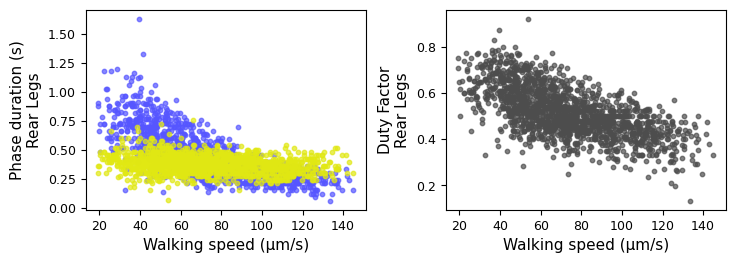

In [8]:
f = plt.figure(figsize=(8,2.5))
legs = ['L4','R4']
ax1 = f.add_axes([0.1,0.1,0.35,0.8])
ax2 = f.add_axes([0.55,0.1,0.35,0.8])
ax1 = stanceSwingPlot(ax1,step_df,legs)
ax2 = dutyFactorPlot(ax2,step_df,legs)

for ax in [ax1,ax2]:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)

plt.show()

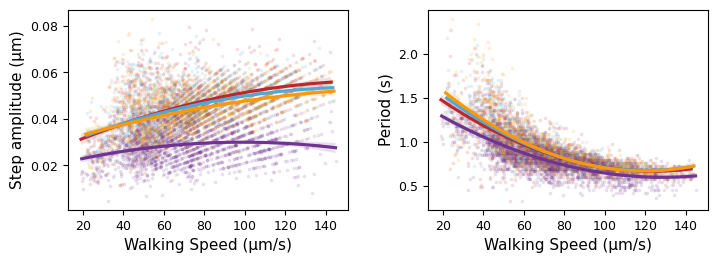

In [9]:
# Speed vs. step amplitude and gait cycle (aka period)
# by LEG PAIR

leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
pair_colors = [first_pair_color, second_pair_color, third_pair_color, rear_leg_color]
data_descriptions = ['Step amplitude (µm)','Period (s)']#,'Swing duration (s)','Stance duration (s)']
data_cols = ['distance_during_step_scaled','gait']# ,'swing','stance']
speed_col = 'speed_during_step_scaled'

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

def scatterCurve(ax,df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab):
    for j, leg_pair in enumerate(leg_pairs):
        
        # get data for this pair for this datatype
        pair_data = df.copy()[df['legID'].isin(leg_pair)]
        pair_data[speed_col] = pair_data[speed_col].values * 1000 # convert to µm
     
        # scatter plot and regression line from seaborn
        sns.regplot(data=pair_data, x=xcol, y=ycol, ax=ax, 
                    scatter_kws ={'s':3,'alpha':0.1}, color=pair_colors[j], order=2) # lowess=True
    ax.xaxis.label.set_text(xlab)
    ax.yaxis.label.set_text(ylab)

    return ax

f = plt.figure(figsize=(8,2.5))
ax1 = f.add_axes([0.1,0.1,0.35,0.8])
ax2 = f.add_axes([0.55,0.1,0.35,0.8])
xcol='speed_during_step_scaled'
xlab='Walking Speed (µm/s)'
ycol='distance_during_step_scaled'
ylab='Step amplitude (µm)'
ax1 = scatterCurve(ax1,step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab)
ycol='gait'
ylab='Period (s)'
ax2 = scatterCurve(ax2,step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab)

for ax in [ax1,ax2]:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)

plt.show()

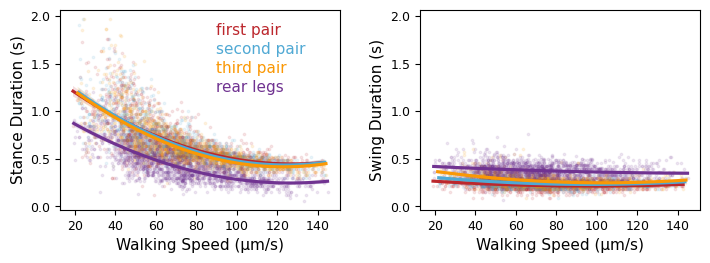

In [10]:
f = plt.figure(figsize=(8,2.5))
ax1 = f.add_axes([0.1,0.1,0.35,0.8])
ax2 = f.add_axes([0.55,0.1,0.35,0.8])
xcol='speed_during_step_scaled'
xlab='Walking Speed (µm/s)'
ycol='stance'
ylab='Stance Duration (s)'
ax1 = scatterCurve(ax1,step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab)
ycol='swing'
ylab='Swing Duration (s)'
ax2 = scatterCurve(ax2,step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab)

def addLegLabs(ax):
    # klugey legend
    leg_labs = ['first pair','second pair', 'third pair','rear legs']
    ytext = 1.8
    yinc = 0.2
    xtext = 90
    for i, leg_lab in enumerate(leg_labs):
        ax.text(xtext,ytext,fontsize=axis_fontsize,color=pair_colors[i],s=leg_lab)
        ytext -= yinc
    return ax

ax1 = addLegLabs(ax1)

for ax in [ax1,ax2]:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)
    
ylim = ax1.get_ylim()
ax2.set_ylim(ylim)
plt.show()

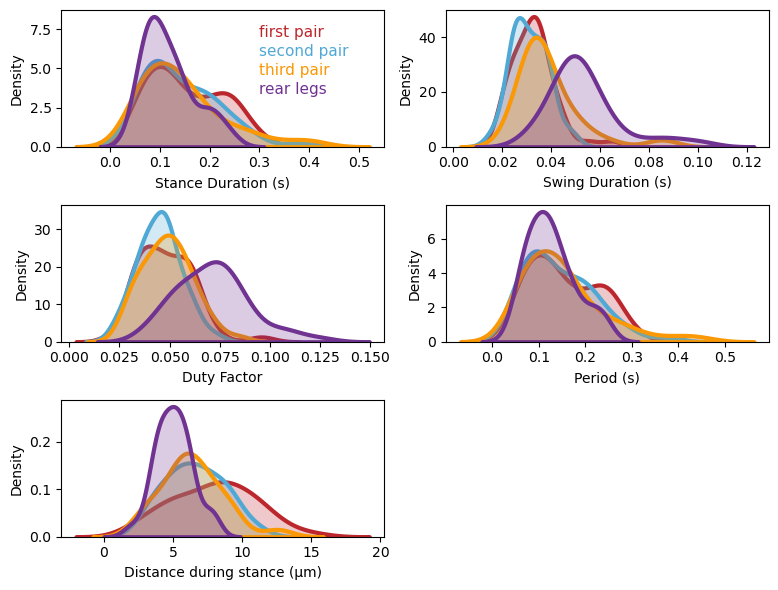

In [11]:
'''
# Variance in step kinematics, Nirody Figure S2

The labels are messed up on their figure ... they use the S1 panel labels, 
and it is not clear what units they are using for the y-axes.<br>

Within-animal standard deviation of kinematic parameters (by leg)<br>
They do step amplitude, period, swing, stance (but not duty factor) 

If I am understanding the figure correctly ... they are taking SD from 
each animal, and making a histogram of those values across multiple animals?

'''

def sdPlot(ax, df, parameter, parameter_label, binwidth, leg_pairs, pair_labels, pair_colors):

    # get unique individuals
    individuals = np.sort(np.unique(df.uniq_id.values))
    
    # for each leg pair
    for j,leg_pair in enumerate(leg_pairs):

        leg_pair_data = df[df['legID'].isin(leg_pair)]
        
        # make empty list for std
        std_vals = []

        # for each individual
        for individual in individuals:
            
            individual_data = leg_pair_data[leg_pair_data['uniq_id']==individual][parameter].values
            
            if parameter == 'distance_during_step_scaled':
                individual_data = individual_data * 1000 # convert mm to µm
        
            # calculate std for parameter, and add to empty list
            std_for_parameter = np.nanstd(individual_data)
            std_vals.append(std_for_parameter)

        # done collecting data for parameter and leg pair ... convert list to numpy array and add to plot
        std_vals = np.array(std_vals)
        
#         ax = sns.histplot(std_vals, ax=ax, binwidth=binwidth, kde=True, stat='probability',
#                  color=pair_colors[j],edgecolor='w',visible=True) # can set to false to hide bars
        
        ax = sns.kdeplot(std_vals, ax=ax, color=pair_colors[j], linewidth=3, fill=True)
        
        ax.set_xlabel(parameter_label)
        
    return ax
    
# load gait data from step_timing sheet
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
parameters = ['stance','swing','duty','gait','distance_during_step_scaled']
parameter_labels = ['Stance Duration (s)','Swing Duration (s)','Duty Factor',
                    'Period (s)','Distance during stance (µm)']
binwidths = np.array([ 0.04, 0.01, 0.01, 0.04, 1])
binwidths *= 0.8

# using leg parameter colors from Figure S1 (Nirody uses different colors)
leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
pair_labels = ['first pair','second pair','third pair','rear legs']
pair_colors = [first_pair_color, second_pair_color, third_pair_color, rear_leg_color]
    
fig, axes = plt.subplots(3,2,figsize=(8,6))
axes_list = axes.flatten()
for i, ax in enumerate(axes_list):
    if i == 5:

        ax.set_axis_off()
        
    else:
        ax = sdPlot(ax, step_df, parameters[i], parameter_labels[i], binwidths[i], 
                    leg_pairs, pair_labels, pair_colors)
        
        if i == 0:
            # klugey legend
            leg_labs = ['first pair','second pair', 'third pair','rear legs']
            ytext = 7
            yinc = 1.2
            xtext = 0.3
            for i, leg_lab in enumerate(leg_labs):
                ax.text(xtext,ytext,fontsize=axis_fontsize,color=pair_colors[i],s=leg_lab)
                ytext -= yinc


plt.tight_layout()
plt.show()

# Combined Figure for individual legs: 
## stance, swing, dutyfactor, gait cycle

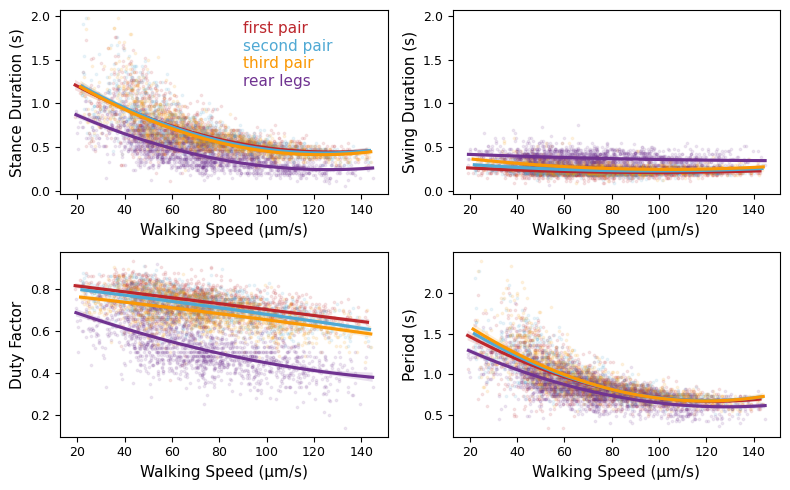

In [12]:
f,axes = plt.subplots(2,2, figsize=(8,5))
axes_list = axes.flatten()

# load gait data from step_timing sheet
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

# Set leg pair colors (Nirody uses different colors)
leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
pair_labels = ['first pair','second pair','third pair','rear legs']
pair_colors = [first_pair_color, second_pair_color, third_pair_color, rear_leg_color]

# stance for individual legs
xcol='speed_during_step_scaled'
xlab='Walking Speed (µm/s)'
ycol='stance'
ylab='Stance Duration (s)'
axes_list[0] = scatterCurve(axes_list[0],step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab)
axes_list[0] = addLegLabs(axes_list[0])

# swing for individual legs
ycol='swing'
ylab='Swing Duration (s)'
axes_list[1] = scatterCurve(axes_list[1],step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab)
ylim = axes_list[0].get_ylim()
axes_list[1].set_ylim(ylim)

# duty factor for individual legs
ycol='duty'
ylab='Duty Factor'
axes_list[2] = scatterCurve(axes_list[2],step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab)

# duty factor for individual legs
ycol='gait'
ylab='Period (s)'
axes_list[3] = scatterCurve(axes_list[3],step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab)

for ax in axes_list:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)

plt.tight_layout()
plt.show()

## offsets: lateral-ipsilateral; lateral-contralateral; rear-contralateral
### lateral-ipsilateral = Nirody Figure 4C "Back-to-front wave of swing initiation"
### lateral-contralateral = Nirody Figure S6B

In [13]:
first_pair = ['L1','R1']
second_pair = ['L2','R2']
third_pair = ['L3','R3']
fourth_pair = ['L4','R4']
rear_legs = fourth_pair
lateral_legs = third_pair + second_pair + first_pair
ipsi_offset_legs = third_pair + second_pair
left_laterals = [x[0] for x in [third_pair, second_pair, first_pair]]
right_laterals = [x[1] for x in [third_pair, second_pair, first_pair]]
all_legs = rear_legs + lateral_legs
left_legs = [x[0] for x in [fourth_pair, third_pair, second_pair, first_pair]]
right_legs = [x[1] for x in [fourth_pair, third_pair, second_pair, first_pair]]
single_leg = ['R4']

# dictionaries of inter-leg relationships
ipsi_legs = {'L4':'L3','R4':'R3','L3':'L2','L2':'L1','R3':'R2','R2':'R1'}
contra_legs = {'L4':'R4','R4':'L4','L3':'R3','L2':'R2','R3':'L3','R2':'L2','L1':'R1','R1':'L1'}

# colors
all_leg_color = 'dimgrey'
L2_L1_color =   second_pair_color
L3_L2_color =   third_pair_color
R2_R1_color =   second_pair_color_alt
R3_R2_color =   third_pair_color_alt

# load data from data_file
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
print(step_df.columns)
step_df.head(3)

Index(['legID', 'DownTime', 'UpTime', 'stance', 'swing', 'gait', 'duty',
       'midSwingTime', 'L1_mid_swings', 'R1_mid_swings', 'L2_mid_swings',
       'R2_mid_swings', 'L3_mid_swings', 'R3_mid_swings', 'L4_mid_swings',
       'R4_mid_swings', 'anterior_swing_start', 'contralateral_swing_start',
       'speed_during_step', 'speed_during_step_scaled', 'distance_during_step',
       'distance_during_step_scaled', 'cruising_during_step',
       'average_tardigrade_area', 'average_tardigrade_length',
       'anterior_offsets', 'contralateral_offsets', 'metachronal_lag',
       'mcl_LR_ratio', 'L3_bearing_change', 'clip', 'treatment', 'individual',
       'date', 'uniq_id'],
      dtype='object')


,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change,clip,treatment,individual,date,uniq_id
0,L1,0.272,1.151,0.879,0.242,1.121,0.7841,1.2720,L1:0.8921,R1:,...,NaN,0.667,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
1,L1,1.393,2.606,1.213,0.303,1.516,0.8001,2.7575,L1:0.9001,R1:0.3701,...,NaN,1.030,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
2,L1,2.909,4.090,1.181,0.334,1.515,0.7795,4.2570,L1:0.8898,R1:0.5597,...,NaN,0.879,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris


# Data table for step kinematics
### Nirody supplemental data table S2

First, get number of steps and amount of time for each individual

Total number of gait cycles analyzed:  5940
Lateral Gait cycles:  4324
Rear Gait cycles:     1616
Number of individuals analyzed:   50


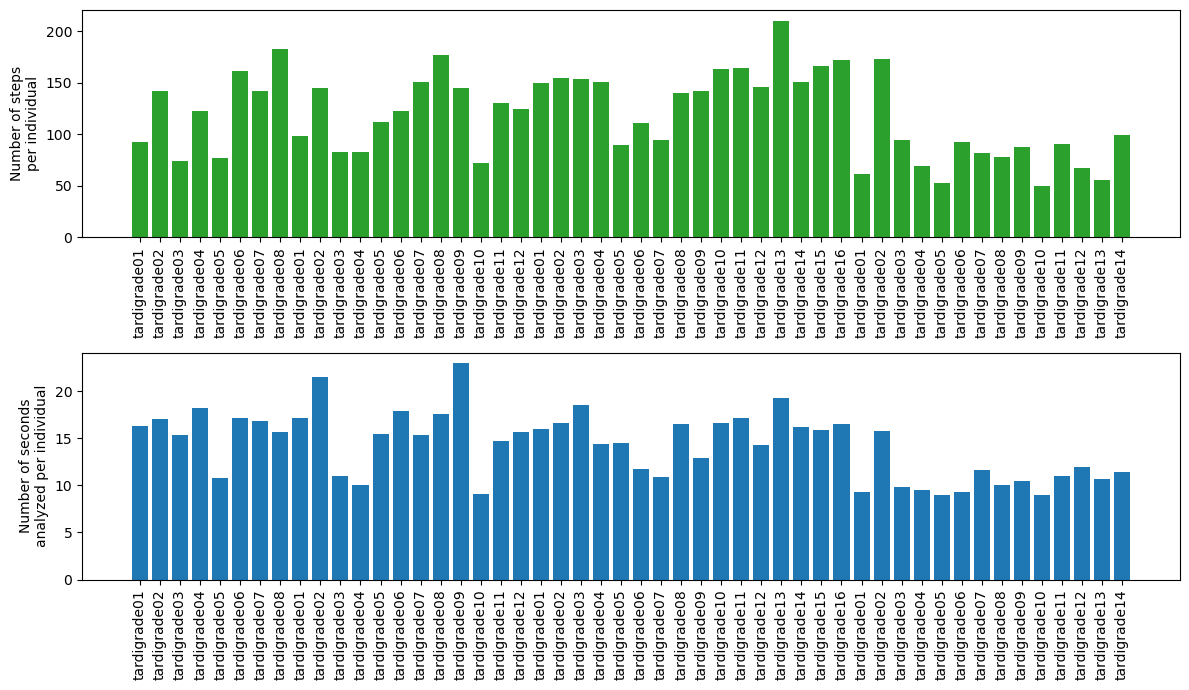

In [14]:
# report number of steps analyzed per individual
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
print('Total number of gait cycles analyzed: ', len(step_df))
print('Lateral Gait cycles: ', len(step_df[step_df['legID'].isin(['L3','L2','L1','R3','R2','R1'])]))
print('Rear Gait cycles:    ', len(step_df[step_df['legID'].isin(['L4','R4'])]))
f,(a1,a2) = plt.subplots(2,1,figsize=(12,7))
steps_analyzed = {} # key = unique id, value = # steps analyzed
individuals = np.sort(np.unique(step_df['uniq_id'].values))
print('Number of individuals analyzed:  ', len(individuals))
for i, individual in enumerate(individuals):
    steps_for_individual = len(step_df[step_df['uniq_id']==individual])
    steps_analyzed[individual] = steps_for_individual
    a1.bar(i, steps_for_individual, color = 'tab:green')
a1.set_ylabel('Number of steps\nper individual')
a1.set_xticks(np.arange(0,len(individuals)))
a1.set_xticklabels([x.split('_')[2] for x in individuals], rotation=90)

# report total time collecting step data per individual
# load data from gait_styles sheet
fps = 33
gait_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
secs_analyzed = dict(zip(individuals,gait_df['Number of frames'].values / fps))
for i, individual in enumerate(individuals):
    a2.bar(i, secs_analyzed[individual], color = 'tab:blue')
a2.set_ylabel('Number of seconds\nanalyzed per individual')
a2.set_xticks(np.arange(0,len(individuals)))
a2.set_xticklabels([x.split('_')[2] for x in individuals], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# WORKING
'''
Need to update the 16 boxplots for steps to include new data … for each of the 50 exemplaris:
    Mean MCL ratios / L3 step (from step_summaries_df)
    Mean abs(MCL ratio)  (compare to and omit the MCL ratio I calculated previously?)
        From step_df = get all ratios for each individual, then abs, then mean
    Bearing changes / L3 step (will need absolute value)
        From step_df = get all bearing changes, then abs, then mean
    Bearing changes / sec steptracking bout
        From step_df = get all bearing changes, then abs, then divide by # secs
'''

Num L3 steps with MCL and bearing:  612 612
Spearman ρ = -0.2  p =  3.6e-07


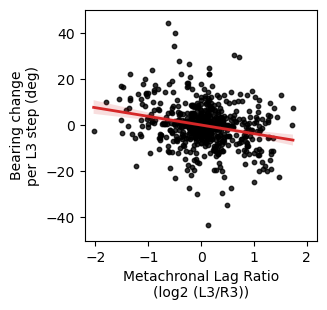

In [38]:
l3_bearing_changes = step_df['L3_bearing_change'].values
mcl_LR_ratio = step_df['mcl_LR_ratio'].values
l3_bearing_changes = gaitFunctions.omitNan(l3_bearing_changes)
mcl_LR_ratio = gaitFunctions.omitNan(mcl_LR_ratio)
print('Num L3 steps with MCL and bearing: ', len(l3_bearing_changes),len(mcl_LR_ratio))
f,a = plt.subplots(1,figsize=(3,3))
sns.regplot(ax=a, x=mcl_LR_ratio, y=l3_bearing_changes, scatter_kws={'s':marker_size,'color':marker_color}, 
                    line_kws={'color':'tab:red','linewidth':2})
a.set_xlabel('Metachronal Lag Ratio\n(log2 (L3/R3))')
a.set_ylabel('Bearing change\nper L3 step (deg)')
a.set_ylim([-50,50])
a.set_xlim([-2.2,2.2])
r,p = stats.spearmanr(mcl_LR_ratio,l3_bearing_changes)
print("Spearman ρ =", np.round(r,2), " p = ", np.round(p,8))
plt.show()

### Compare to Nirody values

In [16]:
''' 
NIRODY Table S2 Values:
'Number of animals': [23,20],
'Body length (μm)':['338.12 ± 45.04','364.53 ± 44.09'],
'Walking speed (μm/s)':['160.50 ± 57.79','91.0 ± 32.0'],
'Step length (μm)': ['90.52 ± 23.70','82.07 ± 19.74'],
'Period (s)': ['0.82 ± 0.24','1.27 ± 0.41'],
'Stance duration (s)': ['0.57 ± 0.21','0.97 ± 0.37'],
'Swing duration (s)': ['0.25 ± 0.08','0.30 ± 0.09'],
'Duty Factor (%)': ['0.68 ± 0.08','0.75 ± 0.07']
'''

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

row_names = ['Number of animals',
             'Body length (μm)',
             'Walking speed (μm/s)',
             'Speed (length/s)',
             'Step length (μm)',
             'Period (s)',
             'Stance duration (s)',
             'Swing duraction (s)',
             'Duty Factor (%)',
            ]

nirody_50pa = ['23','338.12 ± 45.04','160.50 ± 57.79',str(np.round(160.5/338.12,2)),'90.52 ± 23.70',
              '0.82 ± 0.24','0.57 ± 0.21','0.25 ± 0.08','0.68 ± 0.08']

nirody_10pa = ['20','364.53 ± 44.09','91.0 ± 32.0',str(np.round(91/364.53,2)),'82.07 ± 19.74',
              '1.27 ± 0.41','0.97 ± 0.37','0.30 ± 0.09','0.75 ± 0.07']

colname = 'Woodslab'

# load the path summaries data into a dataframe (this has size and speed data)
path_df = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
print(path_df.columns)

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec'],
      dtype='object')


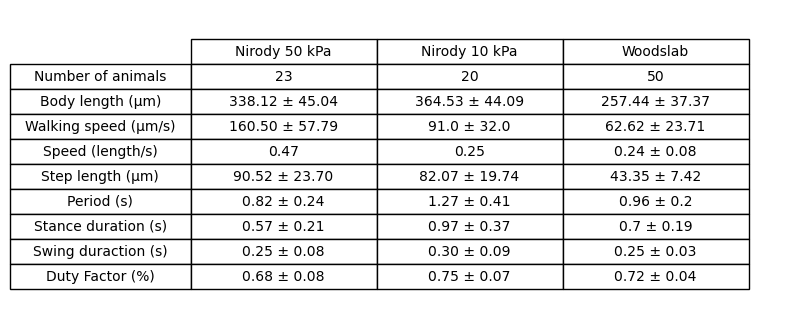

In [17]:
number_animals = str(len(path_df.individual.values))
body_length = meanstdstr(path_df['Body Length (mm)'].values * 1000)
speed_scaled = meanstdstr(path_df['Speed (mm/sec)'].values * 1000) # sec or sec cruising
speed_normalized = meanstdstr(path_df['Speed (body lengths / sec)'].values) # sec or sec cruising
# speed_scaled = meanstdstr(path_df['Speed (mm/sec cruising)'].values * 1000) # sec or sec cruising
# speed_normalized = meanstdstr(path_df['Speed (body lengths / sec cruising)'].values) # sec or sec cruising

# load the step_summaries data into a dataframe (this has step kinematics data)
step_summaries_df = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
step_length = meanstdstr(step_summaries_df['mm per step (lateral legs)'].values * 1000)
period = meanstdstr(step_summaries_df['Gait cycle (lateral legs)'].values)
stance_duration = meanstdstr(step_summaries_df['Stance duration (lateral legs)'].values)
swing_duration = meanstdstr(step_summaries_df['Swing duration (lateral legs)'].values)
duty_factor = meanstdstr(step_summaries_df['Duty factor (lateral legs)'].values)

col_data = [number_animals, body_length, speed_scaled, speed_normalized, step_length,
           period, stance_duration, swing_duration, duty_factor]

table_vals = np.column_stack([nirody_50pa,nirody_10pa,col_data])
col_labels = ['Nirody 50 kPa','Nirody 10 kPa', colname]
row_labels = row_names
row_colors = ['white'] * len(row_labels)
col_colors = ['white'] * len(col_labels)

plt.figure(figsize=(8,4))
ax = plt.gca()

my_table = plt.table(cellText=table_vals,
                     colWidths=[0.3] * len(col_labels),
                     rowLabels=row_labels,
                     rowLoc='center', # left, center, right
                     cellLoc='center',
                     colLoc='center',
                     colLabels=col_labels,
#                      cellColours=cell_colors,
                     rowColours=row_colors,
                     colColours=col_colors,
#                      edges='horizontal',
                     loc='center')
my_table.scale(1, 1.5) # increase vertical space
ax.set_axis_off()
plt.show()

In [18]:
# add seconds analyzed and steps analyzed
step_summaries_df.sort_values(by='Identifier',inplace=True)
secs = [secs_analyzed[x] for x in step_summaries_df['Identifier'].values]
steps = [steps_analyzed[x] for x in step_summaries_df['Identifier'].values]
step_summaries_df['Steps Analyzed'] = steps
step_summaries_df['Seconds Analyzed'] = secs
print(step_summaries_df.columns)
step_summaries_df.head(3)

Index(['Identifier', 'treatment', 'individual',
       'Stance duration (lateral legs)', 'Swing duration (lateral legs)',
       'Gait cycle (lateral legs)', 'Duty factor (lateral legs)',
       'mm per step (lateral legs)', 'bodylength per step (lateral legs)',
       'Stance duration (rear legs)', 'Swing duration (rear legs)',
       'Gait cycle (rear legs)', 'Duty factor (rear legs)',
       'mm per step (rear legs)', 'bodylength per step (rear legs)',
       'Metachronal lag (lateral legs)',
       'Metachronal lag (normalized, lateral legs)',
       'Metachronal lag Left-Right Ratio',
       'Anterior swing offsets (lateral legs)',
       'Anterior swing offsets (normalized, lateral legs)',
       'Opposite swing offsets (lateral legs)',
       'Opposite swing offsets (normalized, lateral legs)',
       'Opposite swing offsets (rear legs)',
       'Opposite swing offsets (normalized, rear legs)', 'Steps Analyzed',
       'Seconds Analyzed'],
      dtype='object')


,Identifier,treatment,individual,Stance duration (lateral legs),Swing duration (lateral legs),Gait cycle (lateral legs),Duty factor (lateral legs),mm per step (lateral legs),bodylength per step (lateral legs),Stance duration (rear legs),...,"Metachronal lag (normalized, lateral legs)",Metachronal lag Left-Right Ratio,Anterior swing offsets (lateral legs),"Anterior swing offsets (normalized, lateral legs)",Opposite swing offsets (lateral legs),"Opposite swing offsets (normalized, lateral legs)",Opposite swing offsets (rear legs),"Opposite swing offsets (normalized, rear legs)",Steps Analyzed,Seconds Analyzed
0,iw_11dec_tardigrade01_exemplaris,exemplaris,tardigrade01,1.038565,0.291355,1.329919,0.775582,0.045352,0.170799,0.531367,...,1.229424,0.345009,0.843844,0.620441,0.653679,0.480877,0.477846,0.495000,92,16.303030
1,iw_11dec_tardigrade02_exemplaris,exemplaris,tardigrade02,0.630924,0.259400,0.890324,0.702079,0.040009,0.167006,0.445486,...,0.896598,0.301717,0.397933,0.438180,0.455132,0.512152,0.410062,0.519129,142,17.090909
2,iw_11dec_tardigrade03_exemplaris,exemplaris,tardigrade03,1.185420,0.313980,1.499400,0.784704,0.049132,0.181463,0.717000,...,1.064675,0.323230,0.819346,0.540057,0.739917,0.485374,0.545450,0.504456,74,15.333333


In [19]:
print('Steps Analyzed: ' + meanstdstr(step_summaries_df['Steps Analyzed'].values))
print('Seconds Analyzed: ' + meanstdstr(step_summaries_df['Seconds Analyzed'].values))
print('Metachronal lag Left-Right Ratio: ' + meanstdstr(step_summaries_df['Metachronal lag Left-Right Ratio'].values))

Steps Analyzed: 118.8 ± 40.02
Seconds Analyzed: 14.26 ± 3.49
Metachronal lag Left-Right Ratio: 0.34 ± 0.25


In [20]:
columns_to_analyze = [
    'Steps Analyzed',
    'Seconds Analyzed',
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
    'Gait cycle (lateral legs)', 
    'Duty factor (lateral legs)',
    'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
    'Gait cycle (rear legs)', 
    'Duty factor (rear legs)',
    'mm per step (rear legs)', 
    'bodylength per step (rear legs)',
    'Metachronal lag (lateral legs)',
    'Metachronal lag (normalized, lateral legs)',
    'Metachronal lag Left-Right Ratio',
    #'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
    #'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
    #'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)' 
]

column_labels = [
    'Steps Analyzed',
    'Seconds Analyzed',
    'Stance duration - lateral\n(sec)', 
    'Swing duration - lateral\n(sec)',
    'Period - lateral\n(sec)', 
    'Duty factor - lateral',
    'Distance / step - lateral\n(mm)', 
    'Distance / step - lateral\n(body length)',
    'Stance duration - rear\n(sec)', 
    'Swing duration - rear\n(sec)',
    'Period - rear\n(sec)', 
    'Duty factor - lateral',
    'Distance / step - rear\n(mm)', 
    'Distance / step - rear\n(body length)',
    'Metachronal lag \n',
    'Metachronal lag / Period',
    'Metachronal lag Log Ratio',
    #'Anterior swing offsets (lateral legs)',
    'Ipsilateral swing offset / Period',
    #'Opposite swing offsets (lateral legs)',
    'Contralateral swing offset / Period\nlateral',
    #'Opposite swing offsets (rear legs)',
    'Contralateral swing offset / Period\nrear' 
]
print(len(columns_to_analyze))

20


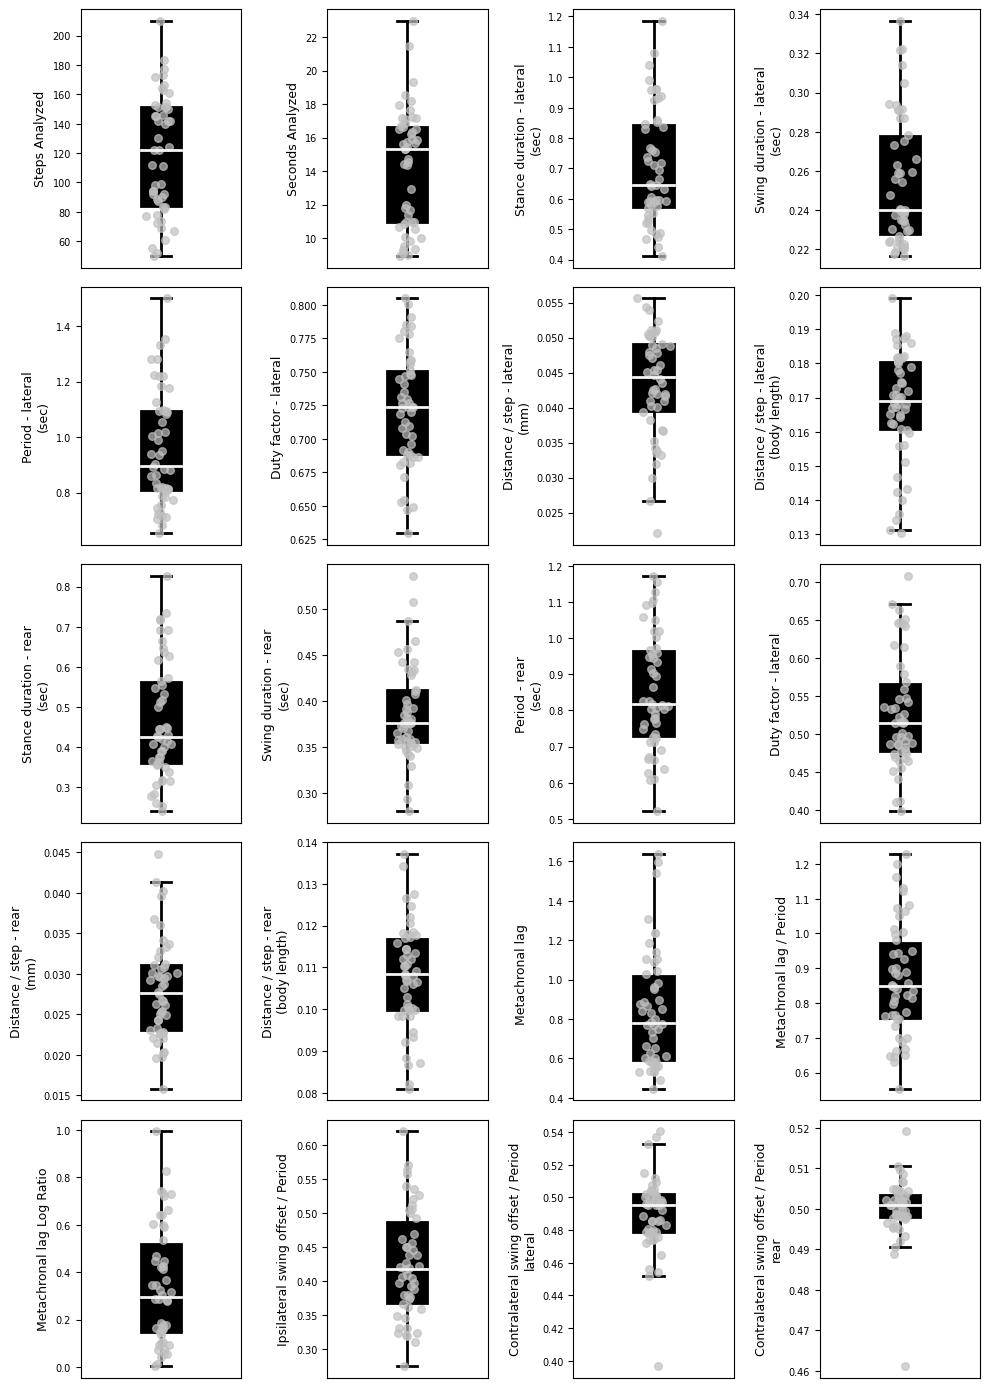

In [21]:
rows,cols = [5,4]
f,axes = plt.subplots(rows,cols,figsize = (10,14))
axes_list = axes.reshape(1,len(columns_to_analyze))[0]
for i, col in enumerate(columns_to_analyze):
    axes_list[i] = gaitFunctions.singleBoxplot(axes_list[i], step_summaries_df, col)
    axes_list[i].yaxis.label.set_text(column_labels[i])
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize-2)

plt.tight_layout()
plt.show()

In [22]:
# make a table of the data ... can screenshot this?
means = [np.round(np.mean(step_summaries_df[col].values),2) for col in columns_to_analyze]
sds = [np.round(np.std(step_summaries_df[col].values),2) for col in columns_to_analyze]
meanstd = [str(m) + ' ± ' + str(sds[i]) for i,m in enumerate(means)]
summary_df = pd.DataFrame({'Measurement':columns_to_analyze,
                          'Mean':means,
                          'SD':sds,
                          'Mean ± Std':meanstd})
blankIndex=[''] * len(summary_df)
summary_df.index=blankIndex
display(summary_df[['Measurement','Mean ± Std']])

,Measurement,Mean ± Std
,Steps Analyzed,118.8 ± 40.02
,Seconds Analyzed,14.26 ± 3.49
,Stance duration (lateral legs),0.7 ± 0.19
,Swing duration (lateral legs),0.25 ± 0.03
,Gait cycle (lateral legs),0.96 ± 0.2
,Duty factor (lateral legs),0.72 ± 0.04
,mm per step (lateral legs),0.04 ± 0.01
,bodylength per step (lateral legs),0.17 ± 0.02
,Stance duration (rear legs),0.46 ± 0.14
,Swing duration (rear legs),0.39 ± 0.05


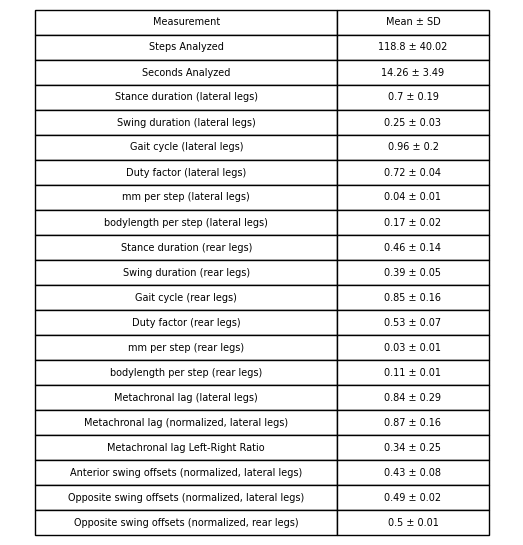

In [23]:
# table in matplotlib figure
fig,ax = plt.subplots(figsize=(6.5,4))

table_vals = np.column_stack([np.array(columns_to_analyze), summary_df['Mean ± Std'].values])
col_labels = ['Measurement','Mean ± SD']
col_colors = ['white'] * len(col_labels)

my_table = plt.table(loc='center',
                     cellText=table_vals,
                     colWidths=[0.6,0.3],
                     rowLoc='center', # left, center, right
                     cellLoc='center',
                     colLoc='center',
                     colLabels=col_labels,
                     colColours=col_colors
                    )

my_table.scale(1, 1.5) # increase vertical space
ax.set_axis_off()
ax.axis('off')
plt.show()

In [24]:
# Table as a plotly figure
# can change colors, sizes, etc, see https://plotly.com/python/figure-factory-table/
# looks pretty good
import plotly.figure_factory as ff
fig = ff.create_table(summary_df[['Measurement','Mean ± Std']])
fig.update_layout(
    autosize=True,
    width=550,
    height=500,
)
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 11
fig.write_image("step_kinematics_summary_table_plotly.png", scale=2)

In [25]:
# can also save as an excel file ... 
out_file = 'step_summaries.xlsx'
with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
    summary_df[['Measurement','Mean ± Std']].to_excel(writer, index=False, sheet_name='step_summaries')

# Podograms
### Nirody Figure 1C

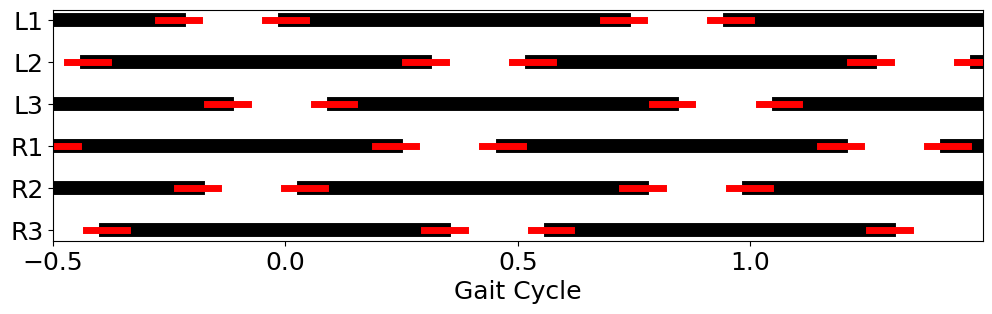

In [26]:
'''
red bars show std of stance duration and swing duration

The code below will make a podogram from the step_summaries sheet,
which contains average data for all lateral legs (and for rear legs).
''' 
plot_order = ['R3','R2','R1','L3','L2','L1']

# load the step_summaries data into a dataframe
step_summaries_df = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
stances = step_summaries_df['Stance duration (lateral legs)'].values / step_summaries_df['Gait cycle (lateral legs)'].values
swings = step_summaries_df['Swing duration (lateral legs)'].values / step_summaries_df['Gait cycle (lateral legs)'].values
gait_cycles = step_summaries_df['Gait cycle (lateral legs)'].values
ipsilateral_offset_mean = np.mean(step_summaries_df['Anterior swing offsets (normalized, lateral legs)'].values)
contralateral_offset_mean = np.mean(step_summaries_df['Opposite swing offsets (normalized, lateral legs)'].values)

stances_mean = np.mean(stances)
stances_std = np.std(stances)
swings_mean = np.mean(swings)
swings_std = np.std(swings)
gait_cycle_mean = np.mean(gait_cycles)

# get leg offsets for plot
leg_offsets = {}
for i, leg in enumerate(['R3','R2','R1']):
    leg_offsets[leg] = i * ipsilateral_offset_mean
for leg in ['R3','R2','R1']:
    contralateral_leg = 'L' + leg[1:]
    leg_offsets[contralateral_leg] = leg_offsets[leg] + contralateral_offset_mean
start_leg = 'L1'
plot_leg_offsets = {}
for k,v in leg_offsets.items():
    plot_leg_offsets[k] = leg_offsets[k] - leg_offsets[start_leg]

# set up plot
f,a = plt.subplots(1, figsize = (12,3))

# it looks like Nirody is plotting data for each leg separately (e.g. the error bars are different)
# should we do that? Or get data for each leg and plot independently?
# if we get data for each leg, how to deal with variation in step number between individual animals?
for i,leg in enumerate(plot_order):
    first_start = plot_leg_offsets[leg]
    for j in [-1,0,1,2]:
        start_stance = first_start + (j * gait_cycle_mean)
        end_stance = start_stance + stances_mean
        # plot stances
        plt.plot([start_stance,end_stance],[i,i],'k',linewidth=10)
        # plot stance errors
        plt.plot([end_stance-stances_std,end_stance+stances_std],[i,i],'r',linewidth=5)
        # plot swing_errors
        plt.plot([start_stance-swings_std,start_stance+swings_std],[i,i],'r',linewidth=5)

xlims = [-0.5,1.5]     
a.set_xlim(xlims)  
a.set_xlabel('Gait Cycle',fontsize=18)
a.set_xticks(np.arange(xlims[0],xlims[1],0.5))
a.set_yticks(np.arange(0,len(plot_order)))
a.set_yticklabels(plot_order)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

ipsilateral offset mean:   0.42
contralateral offset mean: 0.49


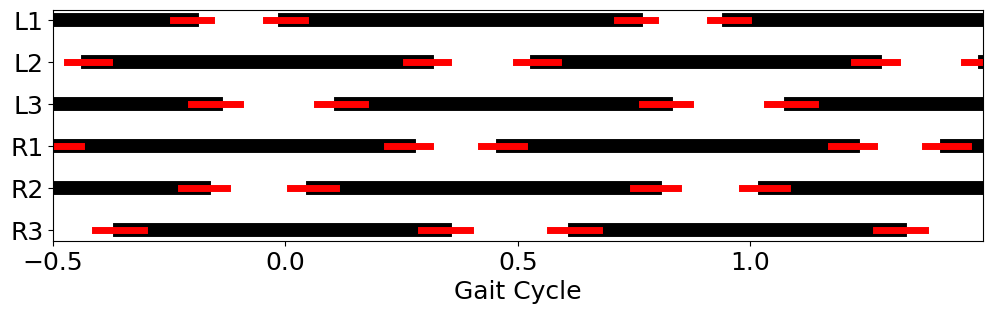

In [27]:
'''
Nirody figure 1C ... podogram 
red bars show std of stance duration and swing duration

The code below will make a podogram from the step_timing sheet,
which contains data for each step for each leg for each individual

We will calculate average stance, swing, gait cycle values for each leg 
of each individual animal, and then plot averages of these
''' 
plot_order = ['R3','R2','R1','L3','L2','L1']

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
# print(step_df.head(3)) # testing

# for each individual, for each leg, get:
# number of steps, stance durations, swing durations, 
# store in dictionary: step_data[leg][parameter] = [mean values for each individual]
step_data = {}
individuals = sorted(np.unique(step_df['uniq_id'].values))
parameters = ['stance','swing','gait','duty','anterior_offsets','contralateral_offsets']

# set up empty dictionary
for leg in plot_order:
    step_data[leg] = {}
    step_data[leg]['number_of_steps'] = []
    for parameter in parameters:
        step_data[leg][parameter] = []
total_steps = {}  # key = individual ID, val = total steps in analysis
total_steps_overall = 0
        
# get the data for each individual and each leg, and add average value to dictionary
for individual in individuals:
    
    total_steps[individual] = 0
    
    # get slice of data for this individual
    individual_df = step_df[step_df['uniq_id'] == individual]
    for leg in plot_order:
        # get slice of data for this leg
        leg_df = individual_df[individual_df['legID']==leg]
        for parameter in parameters:

            # get data for this parameter for this leg for this individual
            parameter_data = leg_df[parameter].values

            # get mean value of this data ... 
            # need some care - some data contains nan
            # and some paramaters will have no data!
            if len(parameter_data) > 0 and np.any(~np.isnan(parameter_data)):
                mean_parameter_data = np.nanmean(parameter_data)
            else:
                mean_parameter_data = np.nan
            
            # append this mean value to the dictionary
            step_data[leg][parameter].append(mean_parameter_data)
            
            # keep track of number of steps per individual and per leg
            if parameter == 'stance':
                # count number of steps
                number_of_steps = len(parameter_data)
                step_data[leg]['number_of_steps'].append(number_of_steps)
                total_steps[individual] += number_of_steps
                total_steps_overall += number_of_steps

# To find inter-leg timing, we will need overall value for
# anterior offsets and contralateral offsets
all_anterior_offsets = []
all_contralateral_offsets = []
for individual in individuals:
    for leg in plot_order:
        all_anterior_offsets.extend(step_data[leg]['anterior_offsets'])
        all_contralateral_offsets.extend(step_data[leg]['contralateral_offsets'])
ipsilateral_offset_mean = np.nanmean(all_anterior_offsets)
contralateral_offset_mean = np.nanmean(all_contralateral_offsets)
print('ipsilateral offset mean:  ', np.round(ipsilateral_offset_mean,2))
print('contralateral offset mean:', np.round(contralateral_offset_mean,2))

# get leg offsets for plot
leg_offsets = {}
for i, leg in enumerate(['R3','R2','R1']):
    leg_offsets[leg] = i * ipsilateral_offset_mean
for leg in ['R3','R2','R1']:
    contralateral_leg = 'L' + leg[1:]
    leg_offsets[contralateral_leg] = leg_offsets[leg] + contralateral_offset_mean
start_leg = 'L1'
plot_leg_offsets = {}
for k,v in leg_offsets.items():
    plot_leg_offsets[k] = leg_offsets[k] - leg_offsets[start_leg]

# set up plot
f,a = plt.subplots(1, figsize = (12,3))

# ready to plot ... 
for i,leg in enumerate(plot_order):
    first_start = plot_leg_offsets[leg]
    gait_cycle_mean = np.nanmean(step_data[leg]['gait'])
    stances = np.array(step_data[leg]['stance']) / np.array(step_data[leg]['gait'])
    stances_mean = np.nanmean(stances)
    stances_std = np.nanstd(stances)
    swings = np.array(step_data[leg]['swing']) / np.array(step_data[leg]['gait'])
    swings_std = np.nanstd(swings)
    
    for j in [-1,0,1,2]:
        start_stance = first_start + (j * gait_cycle_mean)
        end_stance = start_stance + stances_mean
        # plot stances
        plt.plot([start_stance,end_stance],[i,i],'k',linewidth=10)
        # plot stance errors
        plt.plot([end_stance-stances_std,end_stance+stances_std],[i,i],'r',linewidth=5)
        # plot swing_errors
        plt.plot([start_stance-swings_std,start_stance+swings_std],[i,i],'r',linewidth=5)

xlims = [-0.5,1.5]     
a.set_xlim(xlims)  
a.set_xlabel('Gait Cycle',fontsize=18)
a.set_xticks(np.arange(xlims[0],xlims[1],0.5))
a.set_yticks(np.arange(0,len(plot_order)))
a.set_yticklabels(plot_order)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()